In [1]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from torchvision import transforms

import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2

from data.FloorPlanLoader import *
from model.VQAE import VQAE
from utils import *
from train import *

#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy

### Hyperparameters

In [2]:
#Hyperparameter
batch_size = 128
n_hiddens = 32
n_residual_hiddens = 32
n_residual_layers = 1
embedding_dim = 64
n_embeddings = 218
beta = .25
lr = 3e-3
noise=False
noise_weight=0.05
img_channel=1

### Load Dataset

In [3]:
data_root = '../data/img_residential_original/'
all_data_dirs = os.listdir(data_root)
newlist = []
for names in all_data_dirs:
    if names.endswith(".png"):
        newlist.append(names)
all_data_dirs = [data_root + str(i) + '.png' for i in range(0,len(newlist))]

In [4]:
class Centeralize(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple): Desired output size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int))
        self.output_size = output_size

    def __call__(self, image):
        tmp = image
        image = torch.sum(image, dim=0)/3
        h, w = image.shape
        half_h = half_w = int(self.output_size/2)
        grid_x = torch.FloatTensor([[i for i in range(0,w)] for j in range(0,h)])
        grid_y = torch.FloatTensor([[j for i in range(0,w)] for j in range(0,h)])
        img_reverse = (image<1).float()
        center_w = int(torch.sum(img_reverse*grid_x)/torch.sum(img_reverse))
        center_h = int(torch.sum(img_reverse*grid_y)/torch.sum(img_reverse))
        top = center_h - half_h
        left = center_w - half_w
        image = tmp[:, top: top + self.output_size,
                      left: left + self.output_size]
        return image
    
composed = transforms.Compose([
                                Centeralize(1000),
                                transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0)),
                                transforms.Grayscale(1),
                                transforms.Resize(112),
                                transforms.CenterCrop(56),
                              ])
def saveto(i):
    img = Image.open(all_data_dirs[i])
    img = np.array(img)/255.0
    img = np.transpose(img[:, :, :3], (2, 0, 1))
    img_tensor = torch.from_numpy(img.astype(np.float32))
    torch.save(composed(img_tensor), data_root + str(i) + '.pt')
for i in range(0,len(all_data_dirs)):
    try:
        saveto(i)
    except:
        pass

In [5]:
#Load Dataset
floor = FloorPlanDataset(root='../data/img_residential_original/',preprocess=True)
val_len = int(len(floor)/10)
train_set, val_set = torch.utils.data.random_split(floor, [len(floor)-val_len, val_len])
data_variance = get_data_variance(train_set)

print(f"data shape: {floor[0].shape}, dataset size: {len(floor)}, data variance: {data_variance}")

data shape: torch.Size([1, 56, 56]), dataset size: 2139, data variance: 0.003749525174498558


In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
validation_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = False)

### Load Best or Train

In [7]:
vqvae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
                n_embeddings, embedding_dim, 
                beta, img_channel).to(device)
optimizer = torch.optim.Adam(vqvae.parameters(), lr=lr, amsgrad=False)
train_res_recon_error = []
test_res_recon_error = []
start_epoch = 0
end_epoch = 150
best_loss = 2

##### load best checkpoint

In [15]:
vqvae.load_state_dict(torch.load("../checkpoint/210-vqae-0.27099426699356294.pt"))
optimizer.load_state_dict(torch.load("../checkpoint/210-adam-0.27099426699356294.pt"))

with open("../checkpoint/210-vqae_train-0.27099426699356294.json") as json_file:
    train_res_recon_error = json.load(json_file)
with open("../checkpoint/210-vqae_test-0.27099426699356294.json") as json_file:
    test_res_recon_error = json.load(json_file)
    
start_epoch = 75
end_epoch = 150
best_loss = 0.17452330009959569

##### train

In [12]:
for epoch in range(150, 250+1):
    with tqdm(train_loader, unit="batch") as tepoch:
        vqvae.train()
        for data in tepoch:
            data_no_noise = data.to(device)
            optimizer.zero_grad()

            if noise:
                data = add_noise(data_no_noise, noise_weight=noise_weight)
            else:
                data = data_no_noise
            vq_loss, data_recon, perplexity = vqvae(data_no_noise)
            recon_error = F.mse_loss(data_recon, data_no_noise) / data_variance
            loss = recon_error + vq_loss
            loss.backward()

            optimizer.step()
            tepoch.set_postfix(loss=float(loss.detach().cpu()))
            train_res_recon_error.append(recon_error.item())

    avg_loss = 0
    vqvae.eval()
    with torch.no_grad():
        for data in validation_loader:
            data = data.to(device)

            vq_loss, data_recon, perplexity = vqvae(data)
            recon_error = F.mse_loss(data_recon, data) / data_variance
            loss = recon_error.item() * batch_size

            avg_loss += loss / val_len
            test_res_recon_error.append(loss)

    if epoch%5==0 and avg_loss<best_loss:
        best_loss = avg_loss
        best_epoch = epoch
        torch.save(vqvae.state_dict(), f"../checkpoint/{best_epoch}-vqae-{best_loss}.pt")
        torch.save(optimizer.state_dict(), f"../checkpoint/{best_epoch}-adam-{best_loss}.pt")
        with open(f"../checkpoint/{best_epoch}-vqae_train-{best_loss}.json", 'w', encoding ='utf8') as json_file:
            json.dump(train_res_recon_error, json_file, ensure_ascii = False)
        with open(f"../checkpoint/{best_epoch}-vqae_test-{best_loss}.json", 'w', encoding ='utf8') as json_file:
            json.dump(test_res_recon_error, json_file, ensure_ascii = False)

    print(f'Validation Loss: {avg_loss}')

100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.81batch/s, loss=0.212]


Validation Loss: 0.34268253845787944


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.36batch/s, loss=0.357]


Validation Loss: 0.34131484412251506


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.39batch/s, loss=0.167]


Validation Loss: 0.44320599909679426


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.55batch/s, loss=0.204]


Validation Loss: 0.3149424270844795


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.57batch/s, loss=0.174]


Validation Loss: 0.328909072517789


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.59batch/s, loss=0.303]


Validation Loss: 0.3238410143785074


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.42batch/s, loss=0.186]


Validation Loss: 0.3200318779743893


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.42batch/s, loss=0.177]


Validation Loss: 0.3446004267589587


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.36batch/s, loss=0.412]


Validation Loss: 0.4952698291187555


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.52batch/s, loss=0.225]


Validation Loss: 0.34676142589587


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.58batch/s, loss=0.178]


Validation Loss: 0.29903893627471206


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.86batch/s, loss=0.171]


Validation Loss: 0.2953673886581206


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.29batch/s, loss=0.305]


Validation Loss: 0.29122223652584456


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.50batch/s, loss=0.163]


Validation Loss: 0.301190004662169


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.28batch/s, loss=0.166]


Validation Loss: 0.30957487939109263


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.34batch/s, loss=1.21]


Validation Loss: 0.3118717032419124


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.24batch/s, loss=0.27]


Validation Loss: 0.41945612374605706


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.54batch/s, loss=0.475]


Validation Loss: 0.36887078441924337


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.21batch/s, loss=0.245]


Validation Loss: 0.3808958564006107


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.01batch/s, loss=0.192]


Validation Loss: 0.3451094739313976


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.39batch/s, loss=0.176]


Validation Loss: 0.2938034702354754


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.56batch/s, loss=0.377]


Validation Loss: 0.28861078074280644


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.50batch/s, loss=0.312]


Validation Loss: 0.28170219385567963


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.59batch/s, loss=0.189]


Validation Loss: 0.3104901649582554


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.40batch/s, loss=0.161]


Validation Loss: 0.28353065168353875


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.59batch/s, loss=0.165]


Validation Loss: 0.29839367933676275


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.37batch/s, loss=0.179]


Validation Loss: 0.35263749243507925


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.46batch/s, loss=0.175]


Validation Loss: 0.2916770720146072


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.53batch/s, loss=0.184]


Validation Loss: 0.31776630598614475


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.01batch/s, loss=0.16]


Validation Loss: 0.30035702163624656


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.29batch/s, loss=0.178]


Validation Loss: 0.30230620657334306


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.54batch/s, loss=0.211]


Validation Loss: 0.29733309499534644


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.37batch/s, loss=0.268]


Validation Loss: 0.3204013931919152


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.48batch/s, loss=0.163]


Validation Loss: 0.2866990980408002


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.48batch/s, loss=0.138]


Validation Loss: 0.29441585451224606


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.45batch/s, loss=0.144]


Validation Loss: 0.32958259045238225


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.35batch/s, loss=0.134]


Validation Loss: 0.3029148477903554


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.52batch/s, loss=0.165]


Validation Loss: 0.32396475026305294


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.45batch/s, loss=0.179]


Validation Loss: 0.30510100064702994


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.57batch/s, loss=0.164]


Validation Loss: 0.27346333427608294


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.53batch/s, loss=0.255]


Validation Loss: 0.285908837833315


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.38batch/s, loss=0.156]


Validation Loss: 0.3425623934033891


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.48batch/s, loss=0.148]


Validation Loss: 0.2641845130024941


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.45batch/s, loss=0.163]


Validation Loss: 0.2790262732707279


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.49batch/s, loss=0.18]


Validation Loss: 0.25302399827840744


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.50batch/s, loss=0.473]


Validation Loss: 0.36312520559964606


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.12batch/s, loss=0.149]


Validation Loss: 0.3174631629191654


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.34batch/s, loss=0.25]


Validation Loss: 0.32437188412661844


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.56batch/s, loss=0.279]


Validation Loss: 0.28562722183729006


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.06batch/s, loss=0.129]


Validation Loss: 0.2583767707359063


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.31batch/s, loss=0.238]


Validation Loss: 0.3083284225822055


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.48batch/s, loss=0.162]


Validation Loss: 0.26592761474036275


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.65batch/s, loss=0.391]


Validation Loss: 0.3148433703212111


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.52batch/s, loss=0.207]


Validation Loss: 0.3140840664715834


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.54batch/s, loss=0.177]


Validation Loss: 0.29127841824097256


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.59batch/s, loss=0.185]


Validation Loss: 0.2754765989634912


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.39batch/s, loss=0.161]


Validation Loss: 0.2661413362888103


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.43batch/s, loss=0.635]


Validation Loss: 0.37690194000100863


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.34batch/s, loss=0.239]


Validation Loss: 0.3878041298736429


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.47batch/s, loss=0.151]


Validation Loss: 0.2688705909979735


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.21batch/s, loss=0.158]


Validation Loss: 0.27099426699356294


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.26batch/s, loss=0.138]


Validation Loss: 0.258238241706096


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.02batch/s, loss=0.175]


Validation Loss: 0.29362040954016744


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.23batch/s, loss=0.151]


Validation Loss: 0.2529339499316865


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.36batch/s, loss=0.165]


Validation Loss: 0.26353534286570657


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.39batch/s, loss=0.147]


Validation Loss: 0.33179393284757375


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.41batch/s, loss=0.122]


Validation Loss: 0.2786357145354222


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.46batch/s, loss=0.155]


Validation Loss: 0.3162690552187638


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.01batch/s, loss=0.203]


Validation Loss: 0.2528265115800598


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.32batch/s, loss=0.303]


Validation Loss: 0.28451148556991357


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.34batch/s, loss=0.152]


Validation Loss: 0.32294190993331406


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.01batch/s, loss=12]


Validation Loss: 5.217143600535504


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.49batch/s, loss=0.982]


Validation Loss: 3.184361847353653


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.43batch/s, loss=0.565]


Validation Loss: 1.2585544854822293


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.36batch/s, loss=0.286]


Validation Loss: 1.147585909131547


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.33batch/s, loss=0.286]


Validation Loss: 0.9358132590710277


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.26batch/s, loss=0.289]


Validation Loss: 0.587623846922682


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.41batch/s, loss=0.224]


Validation Loss: 0.5670918030358256


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.35batch/s, loss=0.199]


Validation Loss: 0.592227774606624


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.47batch/s, loss=0.188]


Validation Loss: 0.5907830609961855


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.51batch/s, loss=0.21]


Validation Loss: 0.5797298592580875


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.56batch/s, loss=7.77]


Validation Loss: 1.2295464529118068


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.54batch/s, loss=1.25]


Validation Loss: 0.9028718617040786


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.57batch/s, loss=0.215]


Validation Loss: 0.7104620776825668


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.42batch/s, loss=0.514]


Validation Loss: 0.5424084014176204


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.44batch/s, loss=0.231]


Validation Loss: 0.49451276394123206


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.57batch/s, loss=0.205]


Validation Loss: 0.46209385473403575


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.54batch/s, loss=0.195]


Validation Loss: 0.4394370961077336


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.62batch/s, loss=0.357]


Validation Loss: 0.46721428884586813


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.61batch/s, loss=0.156]


Validation Loss: 0.44712800934840813


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.35batch/s, loss=0.219]


Validation Loss: 0.5074050079488978


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.31batch/s, loss=0.185]


Validation Loss: 0.4749274455325704


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.68batch/s, loss=0.54]


Validation Loss: 0.4253802948714422


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.35batch/s, loss=0.18]


Validation Loss: 0.4372450421113923


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.48batch/s, loss=0.159]


Validation Loss: 0.4568444910183759


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.56batch/s, loss=0.132]


Validation Loss: 0.48691252587546763


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.44batch/s, loss=0.137]


Validation Loss: 0.45944453852837075


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.46batch/s, loss=0.156]


Validation Loss: 0.48355192085946663


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.53batch/s, loss=0.147]


Validation Loss: 0.42353650661701325


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.44batch/s, loss=0.137]


Validation Loss: 0.4030671813678294


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.51batch/s, loss=0.139]


Validation Loss: 0.4451813138146915


### Visualization

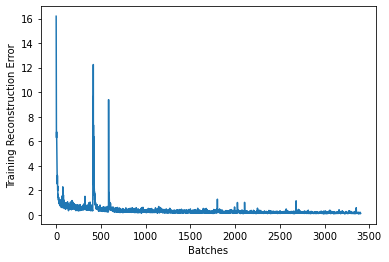

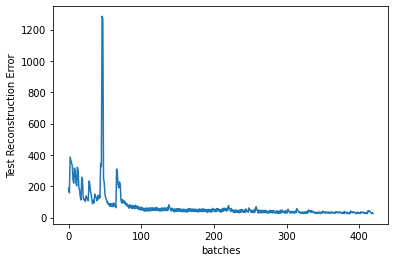

In [16]:
plt.plot(train_res_recon_error[5:])
plt.xlabel('Batches')
plt.ylabel('Training Reconstruction Error')
plt.show()

plt.plot(test_res_recon_error[5:])
plt.xlabel('batches')
plt.ylabel('Test Reconstruction Error')
plt.show()

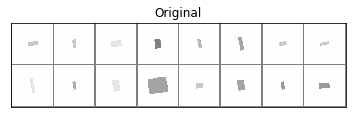

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


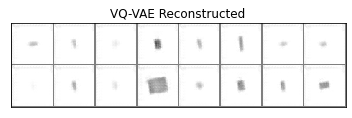

In [18]:
vqvae.eval()
temp_loader = torch.utils.data.DataLoader(val_set,batch_size=16,shuffle=True)
(valid_originals) = next(iter(temp_loader))
valid_originals = valid_originals.to(device)

_, valid_recon, _ = vqvae(valid_originals)
def show(img, title):
    npimg = img.numpy()
#     print(img)
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)


show(torchvision.utils.make_grid(valid_originals.cpu())+0.5, "Original")
plt.show()
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.show()